# **Hate Speech and Offensive Content Detection**

## **1. Business Understanding**
### *Overview*
In Kenya's digital landscape, Twitter plays a critical role in shaping public discourse, especially during election seasons and politically charged events. While it provides a platform for civic engagement, it also facilitates the spread of hate speech, tribalism, and inciting language. This content can escalate tensions and contribute to real-world conflict if left unchecked.
### *Challenges*
Manually moderating large volumes of tweets is inefficient and prone to bias. Current moderation systems struggle to scale and often miss localized forms of hate speech, particularly those specific to Kenyan cultural and political contexts. There is also a lack of automated tools specifically designed to detect offensive content within Kenyan tweets.
### *Proposed Solution*
Develop a machine learning model that can automatically categorize tweets into three classes: hate speech, offensive content, or neither. The model will serve as a content flagging tool for:
Early detection of harmful tweets during elections or national events.
Support for content moderation teams at media outlets, regulatory bodies, and social platforms.
Enhancing digital safety by tracking the evolution and spread of dangerous speech trends.


An effective classification model tailored to the Kenyan context can reduce the spread of inciting content and improve the quality of online public discourse. This system would be vital in promoting peace, especially during sensitive periods like elections.

### *Problem Statement*
There is an urgent need for a localized and scalable hate speech detection system to flag inciting and offensive tweets in Kenya, particularly during political periods where online speech can incite real-world unrest.

### *Objectives*
- To evaluate the most common terms or phrases used in inciting tweets.
- To build a multi-class classification model that labels tweets as hate speech, offensive, or neither.
- To evaluate model performance across different algorithms using accuracy.
- To Deploy the best performing model using Streamlit

## **2 Data Understanding**
The dataset used in this project, HateSpeech_Kenya.csv, was sourced from Kaggle, a well-known platform for sharing datasets and machine learning challenges. It contains approximately 48,000 tweets labeled for sentiment and hate speech, specifically focused on the Kenyan social and political context.
Key Features of the Data:
`tweet`: The raw text of the tweet . this forms the primary input for natural language processing and classification tasks.
`label`: The target variable, where 0 represents neutral content and 1 represents offensive content and 2 represent hate speech.

This dataset is directly aligned with the project goal of developing a machine learning model to detect and categorize hate speech in Kenyan tweets. The inclusion of localized language, real-world offensive content, and metadata allows the model to learn patterns specific to the Kenyan context.


### *Importing Dependencies*

In [1]:
# Data Manipulation
import pandas as pd
import numpy as np

# Text Preprocessing
import re
import string

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# NLP Utilities
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize
from nltk import FreqDist
nltk.download('wordnet')
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer

# Feature Extraction
from sklearn.feature_extraction.text import TfidfVectorizer

# Machine Learning Models
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Filter Warnings
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HomePC\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## **3 Data Preparation**


Using Pandas Library we load our CSV file 'HateSpeech_Kenya.csv' into a Pandas DataFrame (df).

The dataset likely contains tweets along with labels indicating whether they are neutral, offensive, or hate speech. Our dataset has 6 columns, hatespeech, offensive language, neither are columns used to classify our tweet. Class column is the label of our tweet while our tweet column contains the initial tweet post/message.

We mapped our classes to their respective category under the new column named Label

In [2]:
# Loading the dataset, Mapping Class with respective Labels
df = pd.read_csv('HateSpeech_Kenya.csv')
df['Tweet'] = df['Tweet'].apply(lambda x: ' '.join(eval(x)) if isinstance(x, str) else x)
label_map = {0: 'Neutral', 1: 'Offensive', 2: 'Hate Speech'}
df['Label'] = df['Class'].map(label_map)
df.tail()


,hate_speech,offensive_language,neither,Class,Tweet,Label
48071,0,0,2,0,This is exactly what Moses Kuria & ilk are doi...,Neutral
48072,0,0,2,0,This is exactly what Kenyans are going through...,Neutral
48073,0,0,2,0,This is exactly what is wrong with this countr...,Neutral
48074,1,0,2,0,This is exactly the same thing. Well the only ...,Neutral
48075,0,1,2,0,This is exactly how Luos feel in this country ...,Neutral


### *Extracting the Relevant Columns*

From our Dataframe we are going to extract meaningful columns for this analysis: Tweet and the Label/Class Column are our columns of interests for this predictive task

In [3]:
new_df = df[['Tweet', 'Class', 'Label']]
new_df.head()

,Tweet,Class,Label
0,The political elite are in desperation. Ordina...,0,Neutral
1,Am just curious the only people who are callin...,0,Neutral
2,USERNAME_3 the area politicians are the one to...,0,Neutral
3,War expected in Nakuru if something is not don...,0,Neutral
4,USERNAME_4 tells kikuyus activists that they a...,0,Neutral


### *Dataset Summary*

In [4]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48076 entries, 0 to 48075
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Tweet   48076 non-null  object
 1   Class   48076 non-null  int64 
 2   Label   48076 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


From the summary above we find that our dataset is complete, with no missing values and with the correct data types.

### *Checking for Duplicates*

In [5]:
new_df.duplicated().sum()  # Check for duplicates (entire DataFrame)

0

In [6]:
new_df.drop_duplicates(inplace=True)  # Drop duplicates

We found that we have no duplicated values and its in a good condition for analytics since this will avoid bias during our model training, improve generalization and for the purpose of reducing computational costs. 

### *Feature Engineering*

This will involves creating new features (columns) from raw data to improve machine learning model performance. Features like:

Number of characters

Number of sentences

Number of words

will help the model better understand text structure and linguistic patterns

In [7]:
# creating columns for number of characters, number of sentences and number of words
new_df["char"]=new_df["Tweet"].apply(lambda x:len(x))
new_df["words"]=new_df["Tweet"].apply(lambda x:nltk.word_tokenize(x)).apply(lambda x:len(x))
new_df["sentences"]=new_df["Tweet"].apply(lambda x:nltk.sent_tokenize(x)).apply(lambda x:len(x))
new_df.sample(10)

,Tweet,Class,Label,char,words,sentences
46398,Una historia triste de racismo en Irland.,0,Neutral,41,8,1
21912,U aint gat his vote! neither are you going to ...,1,Offensive,114,25,3
15102,When visiting the Maasai Mara you are likely t...,0,Neutral,112,18,1
44218,Where are those Luos with PLS-Posh Luo Syndrom...,0,Neutral,165,27,2
9757,All NASA supporters are currently applying for...,0,Neutral,76,11,1
22579,When pple wake up tomorrow to realize that #Uh...,1,Offensive,133,23,1
33254,USERNAME_4503 sikuelewi hawa ni waluhya ?,0,Neutral,41,6,1
20998,This is Kenya for you #RIPMsando #RIPMusando,0,Neutral,44,9,1
24587,Since 2013 every govt department headed by Jub...,2,Hate Speech,112,18,1
16422,What USERNAME_2737 does #RailaSpeaks #Partners...,0,Neutral,102,10,1


### *Summary Statistics*

In [8]:
new_df.describe()

,Class,char,words,sentences
count,48076.000000,48076.000000,48076.000000,48076.000000
mean,0.310030,110.663637,20.334075,1.807159
std,0.588431,48.989947,9.506031,1.005975
min,0.000000,1.000000,1.000000,1.000000
25%,0.000000,79.000000,14.000000,1.000000
50%,0.000000,111.000000,20.000000,2.000000
75%,0.000000,135.000000,25.000000,2.000000
max,2.000000,327.000000,68.000000,14.000000


### *Check Target Values*

To make sure we have the 3 classes before we continue to our training

In [9]:
features = ['Class', 'Label']
for feature in features:
    print(f"Unique values in {feature}: {new_df[feature].unique()}")

Unique values in Class: [0 1 2]
Unique values in Label: ['Neutral' 'Offensive' 'Hate Speech']


### *Text Cleaning*

Raw tweets often contain noise such as:
- URLs
- Mentions
- Hashtags
- Emojis and non-alphanumeric characters

We'll apply basic text preprocessing to clean the tweet data.


In [10]:
def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # remove URLs
    text = re.sub(r'\@\w+|\#', '', text)  # Remove mentions and hashtags 
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # remove non-alphabetic
    text = text.lower().strip()             # convert to lowercase and strip whitespace
    return text

new_df['Clean_Tweet'] = new_df['Tweet'].apply(clean_text)
new_df.head()

,Tweet,Class,Label,char,words,sentences,Clean_Tweet
0,The political elite are in desperation. Ordina...,0,Neutral,93,14,2,the political elite are in desperation ordinar...
1,Am just curious the only people who are callin...,0,Neutral,138,26,1,am just curious the only people who are callin...
2,USERNAME_3 the area politicians are the one to...,0,Neutral,132,22,1,username the area politicians are the one to b...
3,War expected in Nakuru if something is not don...,0,Neutral,112,23,3,war expected in nakuru if something is not don...
4,USERNAME_4 tells kikuyus activists that they a...,0,Neutral,120,21,3,username tells kikuyus activists that they are...


### EDA

In this section, we will perform the following steps to better understand the structure and characteristics of our tweet dataset:

- Visualize the **distribution of the target classes**
- Analyze the **distribution of tweet lengths (in characters)** across different classes
- Analyze the **distribution of tweet lengths (in words)** across different classes
- Analyze the **distribution of the number of sentences per tweet** across different classes
- Visualize the **most common words** across all tweets
- Visualize the **top words specific to each class**

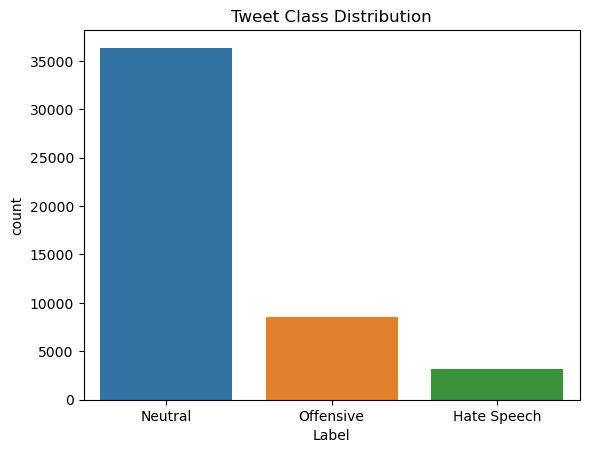

In [11]:
# Class distribution
sns.countplot(data=new_df, x='Label')
plt.title('Tweet Class Distribution')
plt.show()


The bar chart shows a clear class imbalance in the tweet dataset. The majority of tweets are labeled as Neutral, followed by a smaller number labeled as Offensive, and the fewest labeled as Hate Speech. This suggests that neutral content dominates the dataset, while harmful or aggressive language is much less frequent. Such imbalance may impact model training and should be addressed to ensure fair performance across all classes.

### Box plot of the distribution of number of characters accross classes/label

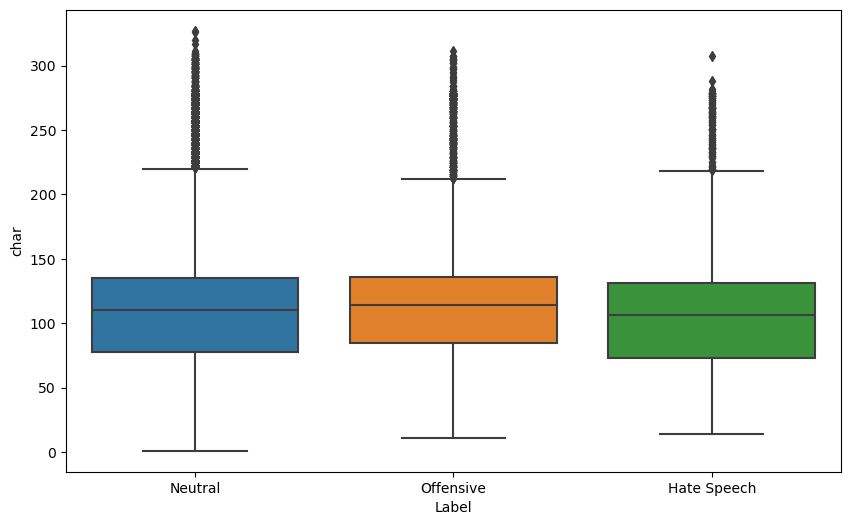

In [12]:

plt.figure(figsize=(10, 6))
sns.boxplot(
    data=new_df,
    x='Label',               
    y='char') 
            
plt.title='Character Count Distribution by Label'
plt.xlabel='Label',
plt.ylabel='Number of Characters'
plt.show()



Overall, the distributions are quite similar, with all three classes—Neutral, Offensive, and Hate Speech—showing a median length slightly above 100 characters. The interquartile ranges are also comparable, though Hate Speech tweets appear slightly shorter on average. All classes contain a large number of outliers above 200 characters, indicating some very long tweets in each category. This suggests that tweet length alone may not strongly differentiate between sentiment classes.

### Box plot of the distribution of number of words accross classes/label

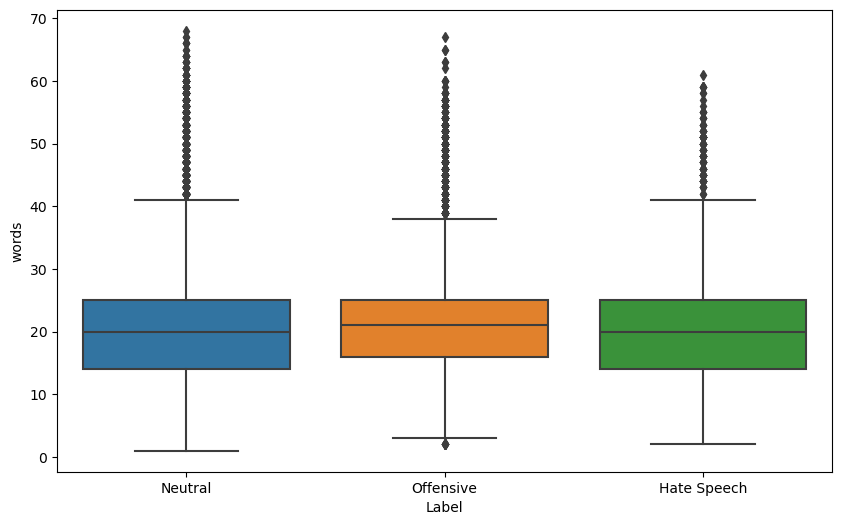

In [13]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=new_df,
    x='Label',               
    y='words') 
            
plt.title='Character Count Distribution by Label'
plt.xlabel='Label',
plt.ylabel='Number of Words'
plt.show()

The boxplot displays the distribution of tweet lengths (in words) across the three sentiment categories. All three classes—Neutral, Offensive, and Hate Speech—have fairly similar distributions, with median word counts around 20. The interquartile ranges also overlap significantly, suggesting that tweet length by word count does not strongly differentiate between the sentiment classes. However, all categories show a wide range of outliers, indicating that some tweets are much longer than average, especially in the Neutral and Offensive categories.

### Box plot of the distribution of number of sentences accross classes/label

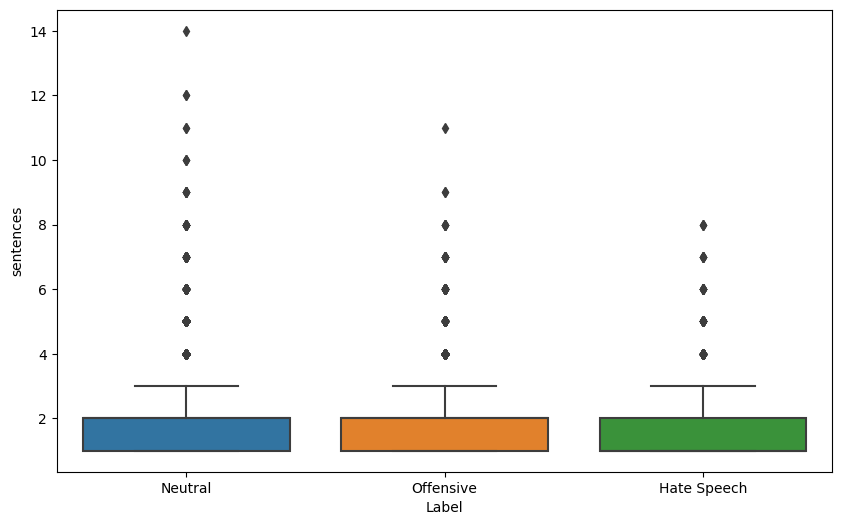

In [14]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=new_df,
    x='Label',               
    y='sentences') 
            
plt.title='Character Count Distribution by Label'
plt.xlabel='Label',
plt.ylabel='Number of Sentences'
plt.show()

All three classes generally contain short tweets, mostly between 1 and 3 sentences. The median sentence count is consistent across categories at around 2, with very similar interquartile ranges, suggesting uniform tweet length regardless of sentiment. However, Neutral tweets exhibit more extreme outliers, with some reaching up to 14 sentences, indicating occasional long-form content. Offensive and Hate Speech tweets also show outliers but to a lesser extent. This implies that while most tweets are brief, Neutral tweets are more likely to include longer discourse.

### Text preprocessing
Tokenizzing , selecting words with 3 or more characters, removing stop words

We will introduce list of english stopwords, Swahili and Sheng(a common street language in Kenya) stop words

We will also initialize WordNetLemmatizer class  responsible for lemmatizing  the tokenned words

In [15]:
# Tokenizer that uses a regex pattern to select words with three or more characters
tokenizer = RegexpTokenizer(r"(?u)\w{3,}")

# List of stopwords in English
english_stopwords = stopwords.words('english')
swahili_stopwords = [
    "a", "na", "ya", "kwa", "wa", "ni", "la", "ili", "katika", "juu", "chini", "kama", "pia", "hadi", "toka",
    "lakini", "kwamba", "hata", "bado", "baada", "mbele", "nyuma", "tu", "tena", "sana", "zote", "wote", "sisi",
    "wao", "wewe", "mimi", "yeye", "huu", "hii", "hawa", "hao", "hizo", "wale", "wetu", "wako", "wangu", "hivyo",
    "au", "kuwa", "ame", "alikuwa", "walikuwa", "si", "ha", "ambapo", "kwani", "ndio", "bila", "kila", "baadhi",
    "mara", "zaidi", "kati", "kupitia"]

sheng_stopwords = [
    "ati", "ajee", "aje", "manze", "yani", "venye", "vile", "niko", "uko", "ako", "nko", "si", "ni", "kaa",
    "hivo", "ivo", "ngori", "ebu", "ah", "lo", "aa", "maze", "fiti", "dem", "boyie", "wasee", "mabeshte", "buda",
    "brathe", "msee", "mresh", "jamaa", "bro", "sis", "sanaa", "kweli", "freshi", "mbogi", "hadi", "balaa",
    "noma", "walai", "ju", "ama", "bado", "mbaya", "vile", "nani", "kitu", "place", "hio", "hiyo", "hii", "ile",
    "nyinyi", "sisi", "mimi", "wewe", "wao", "yeye"
]

# Combine all stopwords list
stopwords_list = set(english_stopwords + swahili_stopwords + sheng_stopwords)

# Use Lemmatizer
lemmatizer = WordNetLemmatizer()

In [16]:
def preprocess_text(text, tokenizer, stopwords_list, lemmatizer):
    text = text.lower()
    tokens = tokenizer.tokenize(text)
    words = [word for word in tokens if word not in stopwords_list]
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return lemmatized_words

### Performing preprocessing on the clean tweet feature


In [17]:
text_data = new_df['Clean_Tweet'].apply(lambda x: preprocess_text(x, tokenizer, stopwords_list, lemmatizer))
text_data.tail()

48071    [exactly, moses, kuria, ilk, say, negative, et...
48072    [exactly, kenyan, going, thank, god, time, ric...
48073    [exactly, wrong, country, kikuyus, cant, stand...
48074    [exactly, thing, well, difference, kilifi, the...
48075    [exactly, luo, feel, country, like, moses, kur...
Name: Clean_Tweet, dtype: object

### Adding preprocessed tweet as a column

In [18]:
new_df["Preprocessed_Tweet"] = text_data
new_df["Clean_Tweet"]

0        the political elite are in desperation ordinar...
1        am just curious the only people who are callin...
2        username the area politicians are the one to b...
3        war expected in nakuru if something is not don...
4        username tells kikuyus activists that they are...
                               ...                        
48071    this is exactly what moses kuria  ilk are doin...
48072    this is exactly what kenyans are going through...
48073    this is exactly what is wrong with this countr...
48074    this is exactly the same thing well the only d...
48075    this is exactly how luos feel in this country ...
Name: Clean_Tweet, Length: 48076, dtype: object

### Frequency Dist Of Preprocessed Words

In [19]:
frequency_dist = FreqDist(new_df['Preprocessed_Tweet'].explode())
frequency_dist

FreqDist({'username': 15521, 'kikuyus': 7361, 'luo': 5223, 'noreformsnoelections': 4032, 'nyakundi': 2932, 'kenya': 2855, 'people': 2673, 'kenyan': 2530, 'like': 2358, 'one': 2125, ...})

### Distribution of top 20 words 

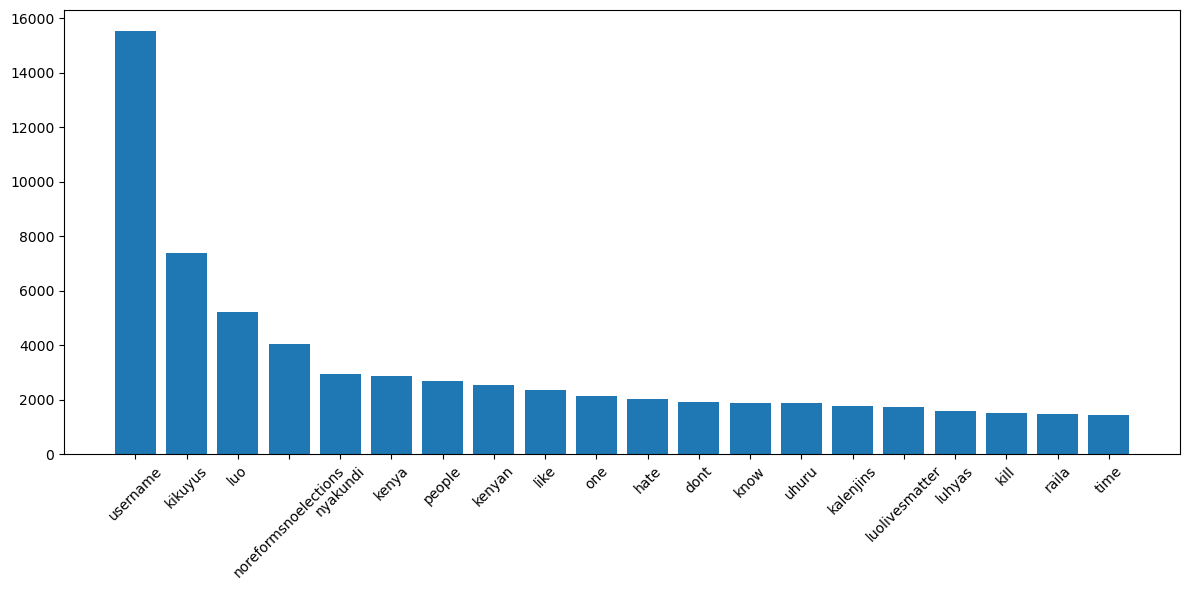

In [20]:

# Sort the dictionary by value (descending)
sorted_dict = dict(sorted(frequency_dist.items(), key=lambda x: x[1], reverse=True))

# Take the top 20 Words
top_20 = dict(list(sorted_dict.items())[:20])

keys = [str(k) for k in top_20.keys()]
values =  list( top_20.values())

plt.figure(figsize=(12, 6))
plt.bar(top_20.keys(), top_20.values())
plt.title=("Distribution of top 20 Words in Tweets")
plt.xlabel=("Words")
plt.ylabel=("Count")
plt.xticks(rotation=45)  

plt.tight_layout()  
plt.show()

## Word Cloud PLot
# from wordcloud import WordCloud

#### Word Cloud

In [21]:
#pip install wordcloud

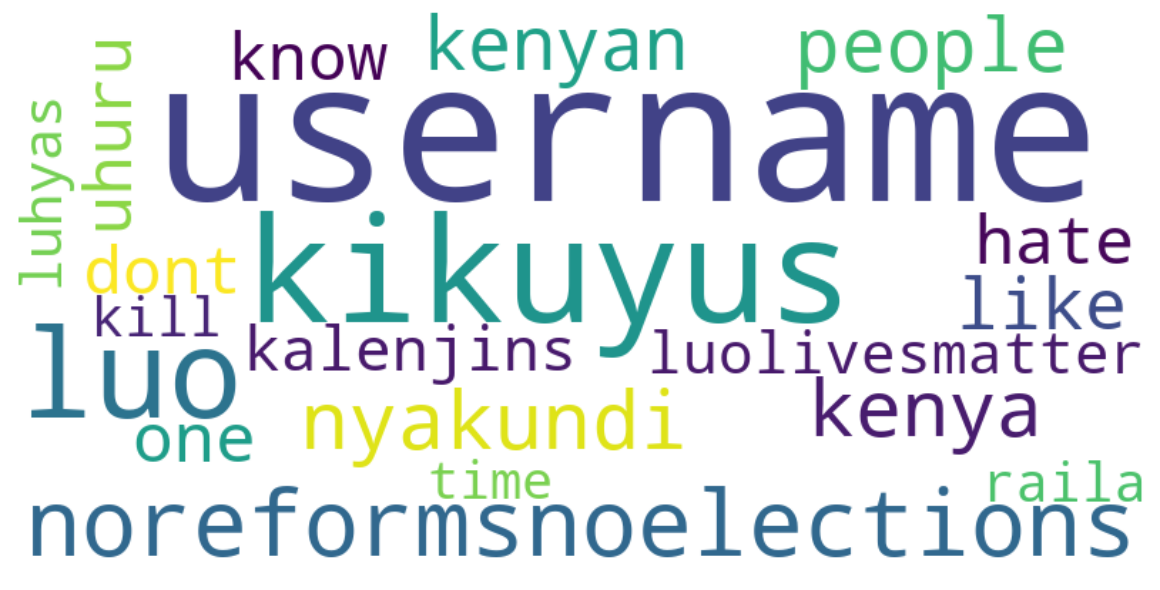

In [22]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Sort the dictionary by value (descending)
sorted_dict = dict(sorted(frequency_dist.items(), key=lambda x: x[1], reverse=True))

# Take the top 20 Words
top_20 = dict(list(sorted_dict.items())[:20])

keys = [str(k) for k in top_20.keys()]
values =  list( top_20.values())

# Generate word cloud from the top 20 words
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis'
).generate_from_frequencies(top_20)

# Plot the word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title="Word Cloud of Top 20 Words in Tweets"
plt.tight_layout()
plt.show()


The word cloud highlights the most frequently used terms across tweets, with larger font sizes indicating higher word frequency. Prominent words like "kikuyus", "noreformsnoelections", "luo", "kenya", and "hate" suggest a strong emphasis on ethnic identity, political slogans, and polarizing language. Terms such as "kill", "know", and "dont" also appear, indicating some aggressive or opinionated tone in the discourse. The presence of multiple ethnic group names — including "kalenjins", "luhyas", and "nyakundi" — reinforces the role of tribal identity in the conversation. Overall, the word cloud reflects a politically and ethnically charged atmosphere within the dataset.

### Getting rid of the word "username"

In [23]:
new_df["Clean_Tweet"] = new_df["Clean_Tweet"].str.replace("username", "", regex=False).str.strip()
  

In [24]:
text_data = new_df['Clean_Tweet'].apply(lambda x: preprocess_text(x, tokenizer, stopwords_list, lemmatizer))
new_df["Preprocessed_Tweet"] = text_data
new_df.head()

,Tweet,Class,Label,char,words,sentences,Clean_Tweet,Preprocessed_Tweet
0,The political elite are in desperation. Ordina...,0,Neutral,93,14,2,the political elite are in desperation ordinar...,"[political, elite, desperation, ordinary, kale..."
1,Am just curious the only people who are callin...,0,Neutral,138,26,1,am just curious the only people who are callin...,"[curious, people, calling, old, mad, kikuyus, ..."
2,USERNAME_3 the area politicians are the one to...,0,Neutral,132,22,1,the area politicians are the one to blame coz ...,"[area, politician, one, blame, coz, insiting, ..."
3,War expected in Nakuru if something is not don...,0,Neutral,112,23,3,war expected in nakuru if something is not don...,"[war, expected, nakuru, something, done, luo, ..."
4,USERNAME_4 tells kikuyus activists that they a...,0,Neutral,120,21,3,tells kikuyus activists that they are being ta...,"[tell, kikuyus, activist, targeted, targetted,..."


### Distribution of Words by LABEL/CLASS

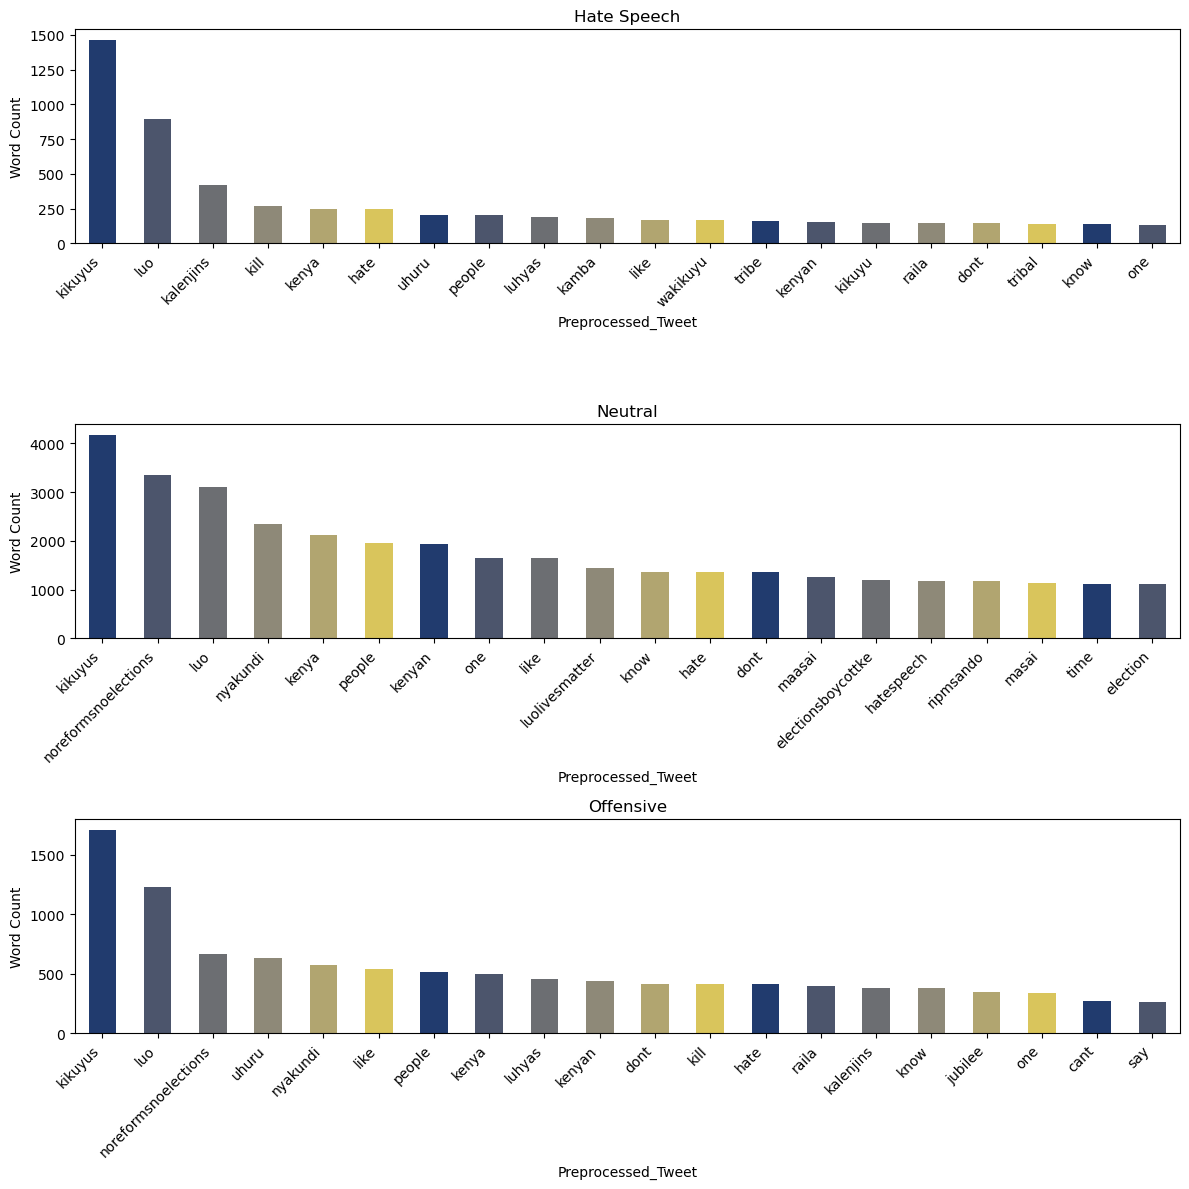

In [25]:
fig, axes = plt.subplots(nrows=3, figsize=(12, 12))
color_palette = sns.color_palette('cividis')  # Unlimited colors from palette

for idx, label_df in enumerate(new_df.groupby('Label')):
    label_name, group_data = label_df
    all_words = group_data['Preprocessed_Tweet'].explode()
    top_20 = all_words.value_counts().nlargest(20)
    
    # Plot with automatic color cycling
    ax = axes[idx]
    top_20.plot.bar(ax=ax, color=color_palette)
    ax.set_title(label_name.title())
    ax.set_xticklabels(top_20.index, rotation=45, ha='right')
    ax.set_ylabel('Word Count')

fig.tight_layout()
plt.show()

 Words like kikuyus, luo, kalenjins, and kenya are dominant in all three categories, highlighting the focus on Kenyan ethnic groups and politics. Hate speech tweets prominently feature tribal identifiers and words associated with violence or negativity, such as kill and hate, indicating targeted hostility. Neutral tweets, in contrast, also center around ethnic groups but with additional election-related terms like morefromselections and election, suggesting a broader, less aggressive discourse. Offensive tweets show a mix of slurs, ethnic mentions, and aggression-related words, though with less concentration on elections compared to neutral tweets. Overall, these visualizations underline the central role of ethnicity and politics in shaping online discourse across all sentiments.

### *Removing Outliers*

In [26]:
new_df=new_df[new_df["sentences"]<4]
len(new_df)

45095

## **4. Modelling**

In this section, we will follow a structured approach to build and evaluate classification models for tweet analysis:

- Fit **baseline models**(Logistic Regression) using two types of text representations:
  - **TF-IDF vectorized tweets**
  - **BERT-based word embeddings**  
  This helps assess initial model performance using both traditional and contextual features.

- Perform **cross-validation** using the following classifiers to identify top-performing models based on the **F1 score**:
  - Logistic Regression  
  - Naive Bayes (TF-IDF only)  
  - Random Forest  
  - XGBoost  

- Address **class imbalance** in the top two models selected from cross-validation using the following resampling techniques:
  - **SMOTE** (Synthetic Minority Oversampling Technique)  
  - **Random undersampling** of the majority class  
  - **Hybrid approach** combining both oversampling and undersampling

- Evaluate the **final performance** of the selected models after applying class imbalance strategies on a held-out test set



### *Undersampling Majority Classes*

In [27]:
new_df["Class"].value_counts()

Class
0    34126
1     7968
2     3001
Name: count, dtype: int64

In [33]:


# Assuming your dataframe is df and the column is 'label'
df_balanced = pd.concat([
    new_df[new_df['Class'] == 0].sample(n=5000, random_state=42),
    new_df[new_df['Class'] == 1].sample(n=5000, random_state=42),
    new_df[new_df['Class'] == 2]  # keep all since it's < 5000
])

# Shuffle the dataset after undersampling
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print(df_balanced['Class'].value_counts())


Class
0    5000
1    5000
2    3001
Name: count, dtype: int64


In [34]:
#defining x and y
X=df_balanced["Preprocessed_Tweet"]
y=df_balanced["Class"]

In [35]:
#train test split 
X_train,X_test,y_train,y_test=train_test_split(X,y,stratify=y,test_size=0.2,random_state=42)

In [36]:
X_train = X_train.apply(lambda x: " ".join(x) if isinstance(x, list) else x)
X_test = X_test.apply(lambda x: " ".join(x) if isinstance(x, list) else x)


### *Baseline Model With TF-IDF*

In [37]:
from sklearn.pipeline import Pipeline

from sklearn.naive_bayes import MultinomialNB
pipeMNB=Pipeline([("vect",TfidfVectorizer()),
    ("clf",LogisticRegression())
            ])
pipeMNB.fit(X_train,y_train)
pred=pipeMNB.predict(X_test)
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.59      0.61      0.60      1000
           1       0.50      0.53      0.52      1000
           2       0.57      0.48      0.52       601

    accuracy                           0.55      2601
   macro avg       0.55      0.54      0.55      2601
weighted avg       0.55      0.55      0.55      2601



The model performs well on class 0, with high precision (0.78), recall (0.97), and F1-score (0.86), indicating that it is strongly biased toward the majority class. However, it performs poorly on classes 1 and 2, with very low recall (0.11 for both) and low F1-scores (0.17), suggesting it fails to correctly identify most instances of the minority classes. While the overall accuracy is 76%, the macro average F1-score is only 0.40, highlighting poor performance across classes and the presence of severe class imbalance.

### *Grid Search*

#### *1. Logistic regression*

#### *2. Random Forest*

#### *3. Naive Bayes*
#### *3.1 Multinomial Naive Bayes*

In [61]:
pipeMNB=Pipeline([("vect",TfidfVectorizer()),
    ("clf",MultinomialNB())
            ])
pipeMNB.fit(X_train,y_train)
pred=pipeMNB.predict(X_test)
print(classification_report(y_test,pred))   

              precision    recall  f1-score   support

           0       0.57      0.55      0.56      1000
           1       0.45      0.68      0.54      1000
           2       0.60      0.12      0.20       603

    accuracy                           0.50      2603
   macro avg       0.54      0.45      0.43      2603
weighted avg       0.53      0.50      0.47      2603



In [62]:
# Parameter grid for ONLY the classifier
from sklearn.model_selection import GridSearchCV
params = {
    'clf__alpha': [0.01, 0.1, 0.5, 1.0],  # Key smoothing parameter
    'clf__fit_prior': [True, False],            # Whether to learn class priors
    'clf__class_prior': [None, [0.3, 0.5, 0.7, 0.9]]      # Optional: Manual priors if imbalanced
}

# Grid search setup (focus only on classifier)
grid = GridSearchCV(
    pipeMNB,
    param_grid=params,
    cv=5,                       # 5-fold cross-validation
    scoring='f1_weighted',       # Or 'accuracy', 'recall', etc.
    n_jobs=-1,                  # Use all CPU cores
    verbose=1                   # Show progress
)

# Fit ONLY on training data
grid.fit(X_train, y_train)

# Best model evaluation
best_model = grid.best_estimator_
pred = best_model.predict(X_test)
print(classification_report(y_test, pred))
print("\nBest parameters:", grid.best_params_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   10.5s finished


              precision    recall  f1-score   support

           0       0.58      0.52      0.55      1000
           1       0.48      0.60      0.53      1000
           2       0.51      0.39      0.44       603

    accuracy                           0.52      2603
   macro avg       0.52      0.50      0.51      2603
weighted avg       0.53      0.52      0.52      2603


Best parameters: {'clf__alpha': 1.0, 'clf__class_prior': None, 'clf__fit_prior': False}


<AxesSubplot:>

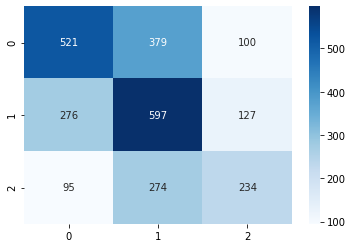

In [67]:
# Plot confusion matrix for MNB classification

sns.heatmap(confusion_matrix(y_test, pred), annot=True, fmt='d', cmap='Blues')


#### *3.1 Complement Naive Bayes*

In [68]:
from imblearn.pipeline import Pipeline
from sklearn.naive_bayes import ComplementNB
pipeCNB = Pipeline([
    ('vect', TfidfVectorizer()),
    ('clf', ComplementNB())
])      # Better for imbalanced data than MultinomialNB
pipeCNB.fit(X_train, y_train)
pred = pipeCNB.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.56      0.56      0.56      1000
           1       0.48      0.49      0.48      1000
           2       0.46      0.46      0.46       603

    accuracy                           0.51      2603
   macro avg       0.50      0.50      0.50      2603
weighted avg       0.51      0.51      0.51      2603



In [69]:
# Parameter grid for ONLY the classifier
params = {
    'clf__alpha': [0.01, 0.1, 0.5, 1.0],  # Smoothing parameter
    'clf__norm': [True, False],             # Whether to normalize weights
    'clf__fit_prior': [True, False]         # Whether to learn class priors
}

# Grid search setup
grid = GridSearchCV(
    pipeCNB,
    param_grid=params,
    cv=5,                       # 5-fold CV
    scoring='f1_weighted',      # Or 'accuracy', 'recall_macro' etc.
    n_jobs=-1,                  # Use all cores
    verbose=1                   # Show progress
)

# Execute search (on training data only)
grid.fit(X_train, y_train)

# Best model evaluation
best_model = grid.best_estimator_
pred = best_model.predict(X_test)
print(classification_report(y_test, pred))
print("\nBest parameters:", grid.best_params_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    8.8s finished


              precision    recall  f1-score   support

           0       0.56      0.56      0.56      1000
           1       0.48      0.49      0.48      1000
           2       0.46      0.46      0.46       603

    accuracy                           0.51      2603
   macro avg       0.50      0.50      0.50      2603
weighted avg       0.51      0.51      0.51      2603


Best parameters: {'clf__alpha': 1.0, 'clf__fit_prior': True, 'clf__norm': False}


<AxesSubplot:>

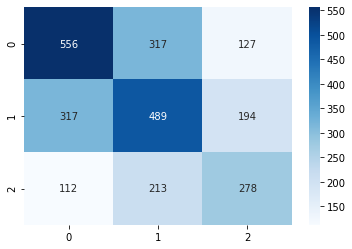

In [70]:
# Plot confusion matrix for CNB classification

sns.heatmap(confusion_matrix(y_test, pred), annot=True, fmt='d', cmap='Blues')

#### *4. XGboost*

In [51]:

from sklearn.model_selection import GridSearchCV


# Define pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('xgb', XGBClassifier(
        objective='multi:softmax',
        num_class=3,               # number of classes
        eval_metric='mlogloss',
        use_label_encoder=False,
        random_state=42
    ))
])

# Parameter grid (with TF-IDF & XGBoost hyperparams)
param_grid = {
    'tfidf__max_features': [5000, 10000],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'xgb__max_depth': [3, 5],
    'xgb__learning_rate': [0.1, 0.2],
    'xgb__n_estimators': [100, 200],
    'xgb__subsample': [0.8, 1.0],
    'xgb__colsample_bytree': [0.8, 1.0]
}

# Grid search
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='f1_weighted',  # could also use 'accuracy'
    cv=3,
    verbose=2,
    n_jobs=-1
)

# Fit
grid_search.fit(X_train, y_train)

# Results
print("Best parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))


Fitting 3 folds for each of 128 candidates, totalling 384 fits
Best parameters: {'tfidf__max_features': 10000, 'tfidf__ngram_range': (1, 2), 'xgb__colsample_bytree': 0.8, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 5, 'xgb__n_estimators': 200, 'xgb__subsample': 0.8}
              precision    recall  f1-score   support

           0       0.52      0.54      0.53       601
           1       0.57      0.67      0.61      1000
           2       0.49      0.40      0.44      1000

    accuracy                           0.54      2601
   macro avg       0.53      0.54      0.53      2601
weighted avg       0.53      0.54      0.53      2601



In [38]:
import re

def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # remove URLs
    text = re.sub(r'@\w+', '', text)     # remove mentions
    text = re.sub(r'#', '', text)        # remove hashtag symbol but keep the word
    text = re.sub(r'[^A-Za-z0-9\s]', '', text)  # remove punctuation/special chars
    text = text.lower().strip()          # lowercase and trim spaces
    return text

df_balanced['clean_tweet'] = df_balanced['Tweet'].astype(str).apply(clean_text)

In [55]:
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import AutoTokenizer, RobertaForSequenceClassification, Trainer
from sklearn.metrics import classification_report
import torch

# ✅ Load your dataframe
df = df_balanced.copy()
df['clean_tweet'] = df['clean_tweet'].astype(str)

# ✅ Encode labels exactly the same way
label2id = {label: i for i, label in enumerate(sorted(df['Label'].unique()))}
id2label = {v: k for k, v in label2id.items()}
df['label'] = df['Label'].map(label2id)

# ✅ Split exactly like before
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['clean_tweet'], df['label'], test_size=0.2, random_state=42
)

# ✅ Load tokenizer and model from saved files
tokenizer = AutoTokenizer.from_pretrained("roberta_model", use_fast=True)
model = RobertaForSequenceClassification.from_pretrained("roberta_model")

# ✅ Tokenization
def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True)

train_dataset = Dataset.from_dict({"text": train_texts.tolist(), "label": train_labels.tolist()})
test_dataset = Dataset.from_dict({"text": test_texts.tolist(), "label": test_labels.tolist()})

train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

# ✅ Evaluate
trainer = Trainer(model=model, tokenizer=tokenizer)
train_preds = trainer.predict(train_dataset)
test_preds = trainer.predict(test_dataset)

print("\nTrain Classification Report:")
print(classification_report(train_dataset["label"], train_preds.predictions.argmax(-1), target_names=label2id.keys()))

print("\nTest Classification Report:")
print(classification_report(test_dataset["label"], test_preds.predictions.argmax(-1), target_names=label2id.keys()))


emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


Map:   0%|          | 0/10400 [00:00<?, ? examples/s]

Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/2601 [00:00<?, ? examples/s]


Train Classification Report:
              precision    recall  f1-score   support

 Hate Speech       0.77      0.91      0.84      2406
     Neutral       0.91      0.87      0.89      3991
   Offensive       0.84      0.79      0.81      4003

    accuracy                           0.85     10400
   macro avg       0.84      0.86      0.85     10400
weighted avg       0.85      0.85      0.85     10400


Test Classification Report:
              precision    recall  f1-score   support

 Hate Speech       0.57      0.73      0.64       595
     Neutral       0.74      0.65      0.69      1009
   Offensive       0.58      0.55      0.57       997

    accuracy                           0.63      2601
   macro avg       0.63      0.65      0.63      2601
weighted avg       0.64      0.63      0.63      2601



### Hybrid method